In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [8]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [9]:
class DNN_7(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_7, self).__init__()
        self.layer1 = nn.Linear(input_dim,64)
        self.layer2 = nn.Linear(64,32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 8)
        self.output_layer = nn.Linear(8, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)        
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        
        x = torch.relu(self.layer2(x))
        x = self.dropout1(x)

        x = torch.relu(self.layer3(x))
        x = self.dropout2(x)

        x = torch.relu(self.layer4(x))
    

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [10]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

Optunaの設定

In [11]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)  
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   

    # モデル定義
    model = DNN_7(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2,
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >0.49).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stopping判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 最終的な評価指標を計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [12]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-04 16:10:44,018] A new study created in memory with name: no-name-54aba706-d805-4c0d-8b79-23a61c177d3a
/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:12:27,100] Trial 0 finished with value: 0.3578259477273763 and parameters: {'dropout1': 0.4, 'dropout2': 0.2, 'learning_rate': 0.0020550008508311924, 'weight_decay': 0.0005321056947270113}. Best is trial 0 with value: 0.3578259477273763.


Early stopping at epoch 35
Final MCC: 0.3578


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:13:15,272] Trial 1 finished with value: 0.34659191007765316 and parameters: {'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'learning_rate': 0.006926274593431494, 'weight_decay': 4.964310241196521e-05}. Best is trial 0 with value: 0.3578259477273763.


Early stopping at epoch 16
Final MCC: 0.3466


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:14:09,699] Trial 2 finished with value: 0.2538060476894739 and parameters: {'dropout1': 0.45, 'dropout2': 0.1, 'learning_rate': 0.0006479362113289573, 'weight_decay': 6.254823448407347e-05}. Best is trial 0 with value: 0.3578259477273763.


Early stopping at epoch 18
Final MCC: 0.2538


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:18:22,884] Trial 3 finished with value: 0.25377466080695305 and parameters: {'dropout1': 0.45, 'dropout2': 0.15000000000000002, 'learning_rate': 4.4905927697967624e-05, 'weight_decay': 0.00010082623046206191}. Best is trial 0 with value: 0.3578259477273763.


Early stopping at epoch 86
Final MCC: 0.2538


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:19:29,326] Trial 4 finished with value: 0.32011378178572664 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.1, 'learning_rate': 0.0005409079430629312, 'weight_decay': 0.0011345267346542314}. Best is trial 0 with value: 0.3578259477273763.


Early stopping at epoch 19
Final MCC: 0.3201


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:19:32,659] Trial 5 pruned. 
[I 2024-12-04 16:25:07,216] Trial 6 finished with value: 0.25409593699294786 and parameters: {'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 1.1542276801748539e-05, 'weight_decay': 0.00019974285987042292}. Best is trial 0 with value: 0.3578259477273763.


Final MCC: 0.2541


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:25:10,599] Trial 7 pruned. 
[I 2024-12-04 16:30:36,776] Trial 8 finished with value: 0.3182192318053801 and parameters: {'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 2.987669898092136e-05, 'weight_decay': 8.065390441124713e-05}. Best is trial 0 with value: 0.3578259477273763.


Early stopping at epoch 94
Final MCC: 0.3182


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:36:29,772] Trial 9 finished with value: 0.2782065177585772 and parameters: {'dropout1': 0.05, 'dropout2': 0.1, 'learning_rate': 1.5986225252076417e-05, 'weight_decay': 1.8399437014376893e-05}. Best is trial 0 with value: 0.3578259477273763.


Final MCC: 0.2782


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:38:52,252] Trial 10 finished with value: 0.29072133077420836 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.5, 'learning_rate': 0.00013172375833968102, 'weight_decay': 0.00833999805277351}. Best is trial 0 with value: 0.3578259477273763.


Early stopping at epoch 37
Final MCC: 0.2907


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:38:55,894] Trial 11 pruned. 
[I 2024-12-04 16:38:59,508] Trial 12 pruned. 
[I 2024-12-04 16:39:03,184] Trial 13 pruned. 
[I 2024-12-04 16:39:06,790] Trial 14 pruned. 
[I 2024-12-04 16:39:10,389] Trial 15 pruned. 
[I 2024-12-04 16:39:13,977] Trial 16 pruned. 
[I 2024-12-04 16:39:17,610] Trial 17 pruned. 
[I 2024-12-04 16:39:21,220] Trial 18 pruned. 
[I

Early stopping at epoch 61
Final MCC: 0.2652


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:43:40,045] Trial 28 pruned. 
[I 2024-12-04 16:43:43,633] Trial 29 pruned. 
[I 2024-12-04 16:43:47,310] Trial 30 pruned. 
[I 2024-12-04 16:49:51,593] Trial 31 finished with value: 0.23954028579243247 and parameters: {'dropout1': 0.5, 'dropout2': 0.05, 'learning_rate': 3.428435295626676e-05, 'weight_decay': 8.296902387431447e-05}. Best is trial 0 with v

Final MCC: 0.2395


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:56:05,790] Trial 32 finished with value: 0.2981438437278138 and parameters: {'dropout1': 0.45, 'dropout2': 0.15000000000000002, 'learning_rate': 2.687473726189432e-05, 'weight_decay': 5.0992194686649766e-05}. Best is trial 0 with value: 0.3578259477273763.


Final MCC: 0.2981


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:00:58,780] Trial 33 finished with value: 0.17899336472094654 and parameters: {'dropout1': 0.45, 'dropout2': 0.1, 'learning_rate': 6.130805704794013e-05, 'weight_decay': 7.250248191130495e-05}. Best is trial 0 with value: 0.3578259477273763.


Early stopping at epoch 78
Final MCC: 0.1790


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:01:02,560] Trial 34 pruned. 
[I 2024-12-04 17:01:06,269] Trial 35 pruned. 
[I 2024-12-04 17:01:10,125] Trial 36 pruned. 
[I 2024-12-04 17:07:30,204] Trial 37 finished with value: 0.30510025713264244 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'learning_rate': 2.1327478791242687e-05, 'weight_decay': 0.0005472527137040169}. Best i

Final MCC: 0.3051


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:10:30,579] Trial 38 finished with value: 0.3353661536031184 and parameters: {'dropout1': 0.4, 'dropout2': 0.1, 'learning_rate': 6.378676265185324e-05, 'weight_decay': 0.00019506125301508174}. Best is trial 0 with value: 0.3578259477273763.


Early stopping at epoch 50
Final MCC: 0.3354


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:14:25,798] Trial 39 finished with value: 0.23089894527429258 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'learning_rate': 8.025639468460553e-05, 'weight_decay': 0.0011765562207378109}. Best is trial 0 with value: 0.3578259477273763.


Early stopping at epoch 68
Final MCC: 0.2309


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:14:28,888] Trial 40 pruned. 
[I 2024-12-04 17:19:35,802] Trial 41 finished with value: 0.31649513887630376 and parameters: {'dropout1': 0.4, 'dropout2': 0.1, 'learning_rate': 1.6934500856214495e-05, 'weight_decay': 0.00016055858593663243}. Best is trial 0 with value: 0.3578259477273763.


Final MCC: 0.3165


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:19:38,916] Trial 42 pruned. 
[I 2024-12-04 17:19:42,014] Trial 43 pruned. 
[I 2024-12-04 17:19:45,137] Trial 44 pruned. 
[I 2024-12-04 17:19:48,230] Trial 45 pruned. 
[I 2024-12-04 17:24:02,930] Trial 46 finished with value: 0.2549354195293067 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.0, 'learning_rate': 3.979444158647681e-05, 'w

Early stopping at epoch 83
Final MCC: 0.2549


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:24:06,016] Trial 47 pruned. 
[I 2024-12-04 17:24:09,152] Trial 48 pruned. 
[I 2024-12-04 17:29:19,262] Trial 49 finished with value: 0.3092393810869658 and parameters: {'dropout1': 0.45, 'dropout2': 0.25, 'learning_rate': 1.3813069911213832e-05, 'weight_decay': 9.915754350044254e-05}. Best is trial 0 with value: 0.3578259477273763.


Final MCC: 0.3092


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:29:22,421] Trial 50 pruned. 
[I 2024-12-04 17:29:25,609] Trial 51 pruned. 
[I 2024-12-04 17:34:30,328] Trial 52 finished with value: 0.31840318331677775 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.15000000000000002, 'learning_rate': 1.9470869060748402e-05, 'weight_decay': 0.00017462435372868386}. Best is trial 0 with value: 0.35782

Final MCC: 0.3184


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:34:33,245] Trial 53 pruned. 
[I 2024-12-04 17:34:36,135] Trial 54 pruned. 
[I 2024-12-04 17:34:39,022] Trial 55 pruned. 
[I 2024-12-04 17:34:41,939] Trial 56 pruned. 
[I 2024-12-04 17:34:44,852] Trial 57 pruned. 
[I 2024-12-04 17:34:47,788] Trial 58 pruned. 
[I 2024-12-04 17:34:50,723] Trial 59 pruned. 
[I 2024-12-04 17:34:53,637] Trial 60 pruned. 
[I

Final MCC: 0.3063


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:40:06,622] Trial 72 pruned. 
[I 2024-12-04 17:40:09,424] Trial 73 pruned. 
[I 2024-12-04 17:40:12,134] Trial 74 pruned. 
[I 2024-12-04 17:40:15,061] Trial 75 pruned. 
[I 2024-12-04 17:44:54,415] Trial 76 finished with value: 0.21983424604872254 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.4, 'learning_rate': 2.3122641839066877e-05, 

Final MCC: 0.2198


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:44:57,241] Trial 77 pruned. 
[I 2024-12-04 17:45:00,003] Trial 78 pruned. 
[I 2024-12-04 17:48:05,539] Trial 79 finished with value: 0.23177068722875452 and parameters: {'dropout1': 0.45, 'dropout2': 0.2, 'learning_rate': 7.891480484174507e-05, 'weight_decay': 0.00011463118008921805}. Best is trial 0 with value: 0.3578259477273763.


Early stopping at epoch 66
Final MCC: 0.2318


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:48:08,383] Trial 80 pruned. 
[I 2024-12-04 17:48:11,199] Trial 81 pruned. 
[I 2024-12-04 17:48:14,013] Trial 82 pruned. 
[I 2024-12-04 17:52:51,146] Trial 83 finished with value: 0.31158585956265517 and parameters: {'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'learning_rate': 2.2092870514810357e-05, 'weight_decay': 0.00019631598830036802}. Best 

Final MCC: 0.3116


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:52:53,975] Trial 84 pruned. 
[I 2024-12-04 17:57:37,031] Trial 85 finished with value: 0.26754531837092377 and parameters: {'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'learning_rate': 4.187033716752879e-05, 'weight_decay': 0.00019493548792847259}. Best is trial 0 with value: 0.3578259477273763.


Final MCC: 0.2675


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:00:56,648] Trial 86 finished with value: 0.23904572186687875 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.35000000000000003, 'learning_rate': 4.9746078097081923e-05, 'weight_decay': 0.0003201633204481409}. Best is trial 0 with value: 0.3578259477273763.


Early stopping at epoch 71
Final MCC: 0.2390


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:00:59,483] Trial 87 pruned. 
[I 2024-12-04 18:05:50,853] Trial 88 finished with value: 0.3058656435219968 and parameters: {'dropout1': 0.4, 'dropout2': 0.4, 'learning_rate': 2.0249649929531074e-05, 'weight_decay': 0.0001509860704857123}. Best is trial 0 with value: 0.3578259477273763.


Final MCC: 0.3059


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:05:53,498] Trial 89 pruned. 
[I 2024-12-04 18:05:55,357] Trial 90 pruned. 
[I 2024-12-04 18:10:41,673] Trial 91 finished with value: 0.34485383454517726 and parameters: {'dropout1': 0.45, 'dropout2': 0.30000000000000004, 'learning_rate': 1.7251719398486167e-05, 'weight_decay': 0.0001253774560434713}. Best is trial 0 with value: 0.3578259477273763.


Final MCC: 0.3449


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:10:44,752] Trial 92 pruned. 
[I 2024-12-04 18:15:37,588] Trial 93 finished with value: 0.3062127263296445 and parameters: {'dropout1': 0.5, 'dropout2': 0.35000000000000003, 'learning_rate': 1.1820972341657357e-05, 'weight_decay': 0.0001745229773998455}. Best is trial 0 with value: 0.3578259477273763.


Final MCC: 0.3062


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:15:40,879] Trial 94 pruned. 
[I 2024-12-04 18:15:43,775] Trial 95 pruned. 
[I 2024-12-04 18:20:36,974] Trial 96 finished with value: 0.34284131510443555 and parameters: {'dropout1': 0.4, 'dropout2': 0.45, 'learning_rate': 2.118715434199362e-05, 'weight_decay': 7.510947694229144e-05}. Best is trial 0 with value: 0.3578259477273763.


Final MCC: 0.3428


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:25:45,785] Trial 97 finished with value: 0.2981438437278138 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'learning_rate': 2.452371439153919e-05, 'weight_decay': 2.361345108853112e-05}. Best is trial 0 with value: 0.3578259477273763.


Final MCC: 0.2981


/tmp/ipykernel_282327/3737011491.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_282327/3737011491.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:25:49,078] Trial 98 pruned. 
[I 2024-12-04 18:31:01,038] Trial 99 finished with value: 0.37873679309192876 and parameters: {'dropout1': 0.4, 'dropout2': 0.1, 'learning_rate': 2.1465550250108514e-05, 'weight_decay': 0.0009541071232561668}. Best is trial 99 with value: 0.37873679309192876.


Final MCC: 0.3787
Best Parameters:  {'dropout1': 0.4, 'dropout2': 0.1, 'learning_rate': 2.1465550250108514e-05, 'weight_decay': 0.0009541071232561668}
Best Validation F1:  0.37873679309192876


Epoch [1/100], Loss: 0.6977
Epoch [1/100], Train Loss: 0.6977, Val Loss: 0.6961
Epoch [2/100], Loss: 0.6931
Epoch [2/100], Train Loss: 0.6931, Val Loss: 0.6904
Epoch [3/100], Loss: 0.6868
Epoch [3/100], Train Loss: 0.6868, Val Loss: 0.6814
Epoch [4/100], Loss: 0.6760
Epoch [4/100], Train Loss: 0.6760, Val Loss: 0.6649
Epoch [5/100], Loss: 0.6614
Epoch [5/100], Train Loss: 0.6614, Val Loss: 0.6463
Epoch [6/100], Loss: 0.6430
Epoch [6/100], Train Loss: 0.6430, Val Loss: 0.6267
Epoch [7/100], Loss: 0.6267
Epoch [7/100], Train Loss: 0.6267, Val Loss: 0.6105
Epoch [8/100], Loss: 0.6165
Epoch [8/100], Train Loss: 0.6165, Val Loss: 0.6017
Epoch [9/100], Loss: 0.6106
Epoch [9/100], Train Loss: 0.6106, Val Loss: 0.5962
Epoch [10/100], Loss: 0.6068
Epoch [10/100], Train Loss: 0.6068, Val Loss: 0.5924
Epoch [11/100], Loss: 0.6004
Epoch [11/100], Train Loss: 0.6004, Val Loss: 0.5893
Epoch [12/100], Loss: 0.5994
Epoch [12/100], Train Loss: 0.5994, Val Loss: 0.5875
Epoch [13/100], Loss: 0.5975
Epoch

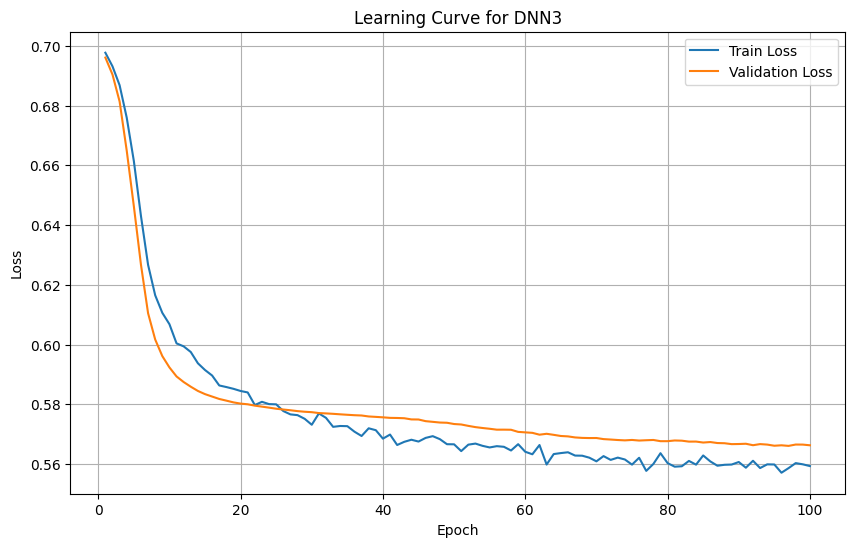

In [13]:
best_params=study.best_params
model = DNN_7(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              ).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN3')
plt.legend()
plt.grid()
plt.show()

Accuracy: 58.66%
Precision: 0.4811
Recall: 0.8997
F1 Score: 0.6269
Matthews Correlation Coefficient: 0.3144
Specificity: 0.3896


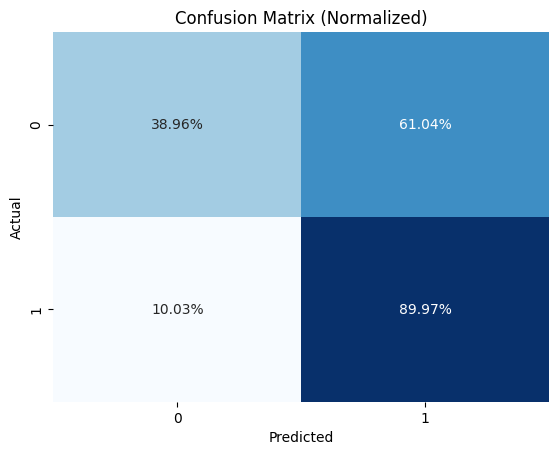

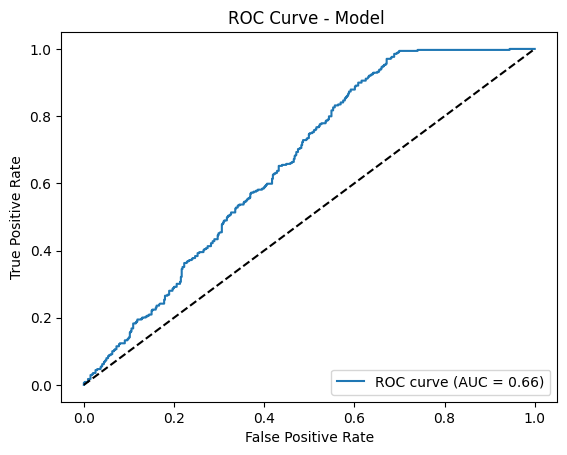

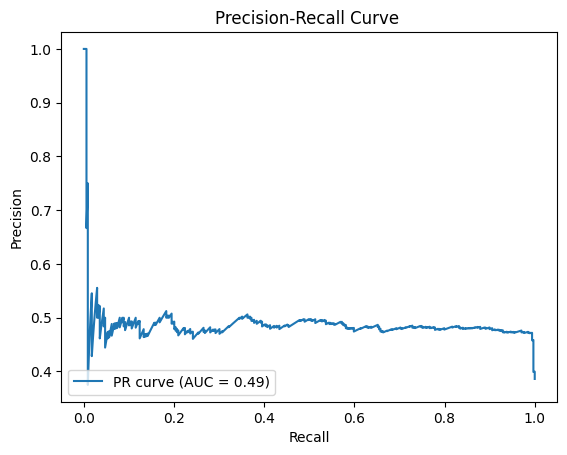

In [14]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [15]:
# モデルと構造を保存
torch.save(model.state_dict(), '../../saved_model/DNN_7.pth')

